In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf
import torch
from torch import nn
from types import SimpleNamespace

from time import time, strftime, gmtime

from sklearn.preprocessing import MinMaxScaler

from loader import *
from bars import *

In [2]:
DATASET_DIR = 'sample_data/'
DATASET_PREFIX = 'BTCUSD'
MODEL_DIR = 'weights/'

In [3]:
params = SimpleNamespace(
    batch_size = 128,
    epochs = 4,
    intraday_freq = pd.Timedelta('00:05:00'),
    train_date = ('2017-05', '2019-06'),
    valid_date = ('2019-07', '2019-12'),
    test_date  = ('2020-01', '2020-09'),
    sample_date = ('2017-05', '2017-06'),
    modelname = f'{MODEL_DIR}.pt',
    train = True,
    num_layers = 1,
    bidirectional = False,
    lr = 0.001
)

In [4]:
def average_ask_bid(df):
    d = {'avg_price': (df.ask + df.bid) / 2, 'avg_volume': (df.ask_volume + df.bid_volume) / 2}
    avg = pd.concat(d.values(), axis=1, keys=d.keys())
    df = pd.concat([df, avg], axis=1)
    return df

In [5]:
def ohlc_format(df):
    df = df[['avg_price','avg_volume']]
    df.columns = df.columns.droplevel()
    df = df.rename(columns={'max': 'High', 'min': 'Low', 'first': 'Open', 'last': 'Close', 'sum': 'Volume'})
    return df

In [6]:
def plot_candlestick(df, N=None):
    if N is not None:
        first = np.random.randint(0, len(df)-N)
        df = df[first:first+N]
    mpf.plot(df, type='candle', style='charles', figratio=(25,8))

In [7]:
def plot_candlestick_steps(df, window, steps=None):
    max_steps = min(len(df), steps) if steps is not None else len(df)
    fig , ax = plt.subplots(1, max_steps-1, figsize=(6,2))
    for i in range(1, max_steps):
        c_df = df[i-1:i-1+window]
        mpf.plot(c_df, type='candle', style='charles', ax=ax[i-1])

In [8]:
start = time()
df = df_load(DATASET_DIR, DATASET_PREFIX, params.sample_date[0], params.sample_date[1])
df = get_timebars(df, params.intraday_freq)
print(f'Time elapsed: {strftime("%H:%M:%S", gmtime(time()-start))}')

Time elapsed: 00:01:06


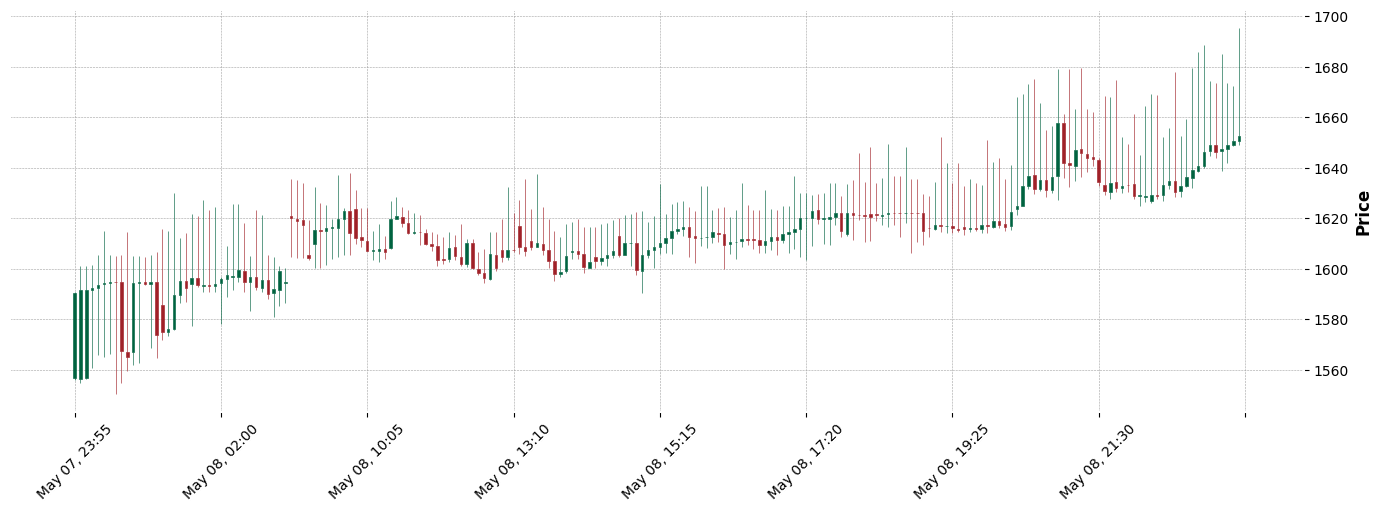

NoneType

In [24]:
type(plot_candlestick(df[0:200]))

In [9]:
df = average_ask_bid(df)
df = ohlc_format(df)

In [10]:
lala = df.copy()

lala['log_body'] = np.log(lala.Close/lala.Open)*10000
lala['log_wick'] = np.log(lala.High/lala.Low)*10000
lala[:10]

In [11]:
lala

,High,Low,Open,Close,Volume
date,,,,,
2017-05-07 23:55:00,1590.75,1556.15,1556.85,1590.60,124.60
2017-05-08 00:00:00,1601.25,1554.75,1556.50,1591.75,8629.50
2017-05-08 00:05:00,1601.30,1556.60,1556.95,1591.55,12477.90
2017-05-08 00:10:00,1601.45,1560.90,1591.55,1592.45,4490.85
2017-05-08 00:15:00,1605.30,1566.05,1592.30,1593.75,12342.05
...,...,...,...,...,...
2017-05-31 23:35:00,2303.10,2297.85,2302.10,2300.30,4342.20
2017-05-31 23:40:00,2301.35,2297.20,2300.35,2298.95,6977.90
2017-05-31 23:45:00,2301.05,2297.50,2299.05,2298.00,20675.30


In [12]:
target_names = ['Close']

In [13]:
shift_days = 1
shift_steps = shift_days * 60 * 24
#shift_steps = 1  # if we want to ship every 5 min, i.e. the same as the params.intraday_freq

In [14]:
df_targets = np.log(df[target_names].shift(-shift_steps)/df[target_names])
df_targets

,Close
date,
2017-05-07 23:55:00,0.133406
2017-05-08 00:00:00,0.134332
2017-05-08 00:05:00,0.134211
2017-05-08 00:10:00,0.134277
2017-05-08 00:15:00,0.134503
...,...
2017-05-31 23:35:00,NaN
2017-05-31 23:40:00,NaN
2017-05-31 23:45:00,NaN


In [29]:
lala.shape

(4123, 5)

In [15]:
x_data = df.values[0:-shift_steps]
print(type(x_data))
print("Shape:", x_data.shape)

print(x_data)

y_data = df_targets.values[:-shift_steps]
print(type(y_data))
print("Shape:", y_data.shape)

print(y_data)

<class 'numpy.ndarray'>
Shape: (2683, 5)
[[ 1590.75  1556.15  1556.85  1590.6    124.6 ]
 [ 1601.25  1554.75  1556.5   1591.75  8629.5 ]
 [ 1601.3   1556.6   1556.95  1591.55 12477.9 ]
 ...
 [ 2384.15  2335.45  2339.9   2351.35 11992.95]
 [ 2366.05  2338.1   2348.8   2357.5  10163.2 ]
 [ 2385.05  2338.9   2358.3   2356.2  15548.2 ]]
<class 'numpy.ndarray'>
Shape: (2683, 1)
[[ 0.13340565]
 [ 0.13433208]
 [ 0.13421053]
 ...
 [-0.02295045]
 [-0.025345  ]
 [-0.02262045]]


In [16]:
train_split = 0.9

num_data = len(x_data)
print(f'num_data: {num_data}')

num_train = int(train_split * num_data)
print(f'num_train: {num_train}')

num_test = num_data - num_train
print(f'num_test: {num_test}')

x_train = x_data[0:num_train]
x_test = x_data[num_train:]
print(f'total: {len(x_train) + len(x_test)}')

y_train = y_data[0:num_train]
y_test = y_data[num_train:]
print(f'total: {len(y_train) + len(y_test)}')

num_x_signals = x_data.shape[1]
print(f'num_x_signals: {num_x_signals}')

num_y_signals = y_data.shape[1]
print(f'num_y_signals: {num_y_signals}')

num_data: 2683
num_train: 2414
num_test: 269
total: 2683
total: 2683
num_x_signals: 5
num_y_signals: 1


In [18]:
print("Min:", np.min(x_train))
print("Max:", np.max(x_train))

x_scaler = MinMaxScaler()

x_train_scaled = x_scaler.fit_transform(x_train)

print("Min:", np.min(x_train_scaled))
print("Max:", np.max(x_train_scaled))

x_test_scaled = x_scaler.transform(x_test)

y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

Min: 0.0
Max: 38532.350000000006
Min: 0.0
Max: 1.0


In [19]:
print(x_train_scaled.shape)
print(y_train_scaled.shape)

(2414, 5)
(2414, 1)


In [23]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)


In [24]:
batch_size = 128
sequence_length = 24 * 7 * 8
sequence_length

generator = batch_generator(batch_size=batch_size,
                            sequence_length=sequence_length)

x_batch, y_batch = next(generator)

print(x_batch.shape)
print(y_batch.shape)

(128, 1344, 5)
(128, 1344, 1)


In [27]:
torch.tensor(x_batch, dtype=torch.long, device=device).shape

torch.Size([128, 1344, 5])

In [129]:
training_generator = torch.utils.data.DataLoader(x_train_scaled, batch_size=batch_size)

In [135]:
training_generator = torch.utils.data.DataLoader(dataset, batch_size=batch_size)

In [29]:
my_iter = iter(training_generator)

In [30]:
A = next(my_iter)

In [31]:
A.shape

torch.Size([128, 5])

In [32]:
A[:5]

tensor([[0.0000, 0.0080, 0.0005, 0.0375, 0.0032],
        [0.0148, 0.0060, 0.0000, 0.0392, 0.2240],
        [0.0149, 0.0087, 0.0006, 0.0389, 0.3238],
        [0.0151, 0.0149, 0.0506, 0.0402, 0.1165],
        [0.0206, 0.0223, 0.0517, 0.0421, 0.3203]], dtype=torch.float64)

In [33]:
x_train_scaled[:5]

array([[0.        , 0.00801907, 0.00050549, 0.03750548, 0.00323365],
       [0.01483889, 0.00599624, 0.        , 0.03918702, 0.22395468],
       [0.01490955, 0.00866927, 0.00064991, 0.03889458, 0.3238292 ],
       [0.01512154, 0.01488224, 0.05062103, 0.04021056, 0.11654752],
       [0.02056246, 0.02232336, 0.05170422, 0.04211142, 0.32030359]])

In [42]:
for i, A in enumerate(training_generator):
    print(A.shape)
print(i)
print(A[109])

torch.Size([128, 5])
torch.Size([128, 5])
torch.Size([128, 5])
torch.Size([128, 5])
torch.Size([128, 5])
torch.Size([128, 5])
torch.Size([128, 5])
torch.Size([128, 5])
torch.Size([128, 5])
torch.Size([128, 5])
torch.Size([128, 5])
torch.Size([128, 5])
torch.Size([128, 5])
torch.Size([128, 5])
torch.Size([128, 5])
torch.Size([128, 5])
torch.Size([128, 5])
torch.Size([128, 5])
torch.Size([110, 5])
18
tensor([0.9353, 0.9300, 0.9744, 0.9520, 0.3731], dtype=torch.float64)


In [136]:

i = 0
for X, y in training_generator:
    print(X.shape, y.shape)
    if i == 0:
        a = X
    if i == 8:
        b = X
    i += 1

torch.Size([128, 4]) torch.Size([128, 1])
torch.Size([128, 4]) torch.Size([128, 1])
torch.Size([128, 4]) torch.Size([128, 1])
torch.Size([128, 4]) torch.Size([128, 1])
torch.Size([128, 4]) torch.Size([128, 1])
torch.Size([128, 4]) torch.Size([128, 1])
torch.Size([128, 4]) torch.Size([128, 1])
torch.Size([128, 4]) torch.Size([128, 1])
torch.Size([128, 4]) torch.Size([128, 1])
torch.Size([128, 4]) torch.Size([128, 1])
torch.Size([128, 4]) torch.Size([128, 1])
torch.Size([128, 4]) torch.Size([128, 1])
torch.Size([128, 4]) torch.Size([128, 1])
torch.Size([128, 4]) torch.Size([128, 1])
torch.Size([128, 4]) torch.Size([128, 1])
torch.Size([128, 4]) torch.Size([128, 1])
torch.Size([128, 4]) torch.Size([128, 1])
torch.Size([128, 4]) torch.Size([128, 1])
torch.Size([110, 4]) torch.Size([110, 1])


In [124]:

i = 0
for X in training_generator:
    print(X.shape)
    if i == 0:
        a = X
    if i == 8:
        b = X
    i += 1

torch.Size([128, 5])
torch.Size([128, 5])
torch.Size([128, 5])
torch.Size([128, 5])
torch.Size([128, 5])
torch.Size([128, 5])
torch.Size([128, 5])
torch.Size([128, 5])
torch.Size([128, 5])
torch.Size([128, 5])
torch.Size([128, 5])
torch.Size([128, 5])
torch.Size([128, 5])
torch.Size([128, 5])
torch.Size([128, 5])
torch.Size([128, 5])
torch.Size([128, 5])
torch.Size([128, 5])
torch.Size([110, 5])


In [137]:
torch.all(torch.eq(a, b))

tensor(False)

In [132]:
class DataSet(torch.utils.data.Dataset):

    def __init__(self, df):
        """Init function should not do any heavy lifting, but
            must initialize how many items are available in this data set.
        """

        self.df = df
        self.features = torch.from_numpy(df[:, :-1]).float()
        self.label = torch.from_numpy(df[:, -1:]).float()

    def __len__(self):
        """return number of points in our dataset"""

        return len(self.df)

    def __getitem__(self, idx):
        """ Here we have to return the item requested by `idx`
            The PyTorch DataLoader class will use this method to make an iterable for
            our training or validation loop.
        """
        
        X = self.features[idx]
        y = self.label[idx]
        
        return X, y

In [133]:
dataset = DataSet(df=x_train_scaled)

In [134]:
x_train_scaled.shape

(2414, 5)

In [26]:
# Select device
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    print("WARNING: Training without GPU can be very slow!")

In [50]:
class LSTM_Forecaster(torch.nn.Module):

    def __init__(self, input_size, hidden_size, output_size, num_layers=1, bidirectional=False):
        super().__init__()
        
        self.hidden_size = hidden_size
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, bidirectional=bidirectional)
        self.linear = torch.nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        output, _ = self.rnn(x)
        output = self.linear(output)
        return output

In [51]:
training_generator = torch.utils.data.DataLoader(x_train_scaled,
                                                 batch_size=batch_size)

In [62]:

training_losses = []

def train(model, optimizer, criterion, train_generator, log=False):
    model.train()
    total_loss = 0
    niterations = 0
    for X, y in train_generator:
        # Get input and target sequences from batch
        # X = torch.tensor(X, dtype=torch.long, device=device)
        # y = torch.tensor(y, dtype=torch.long, device=device)
        
        X, y = X.to(device), y.to(device)
        
        # Clears old gradients from the last step (otherwise you’d just accumulate the gradients from all loss.backward() calls)
        model.zero_grad()
        output = model(X)
        loss = criterion(output, y)
        # Computes the derivative of the loss w.r.t. the parameters (or anything requiring gradients) using backpropagation.
        loss.backward()
        # Causes the optimizer to take a step based on the gradients of the parameters.
        optimizer.step()
        
        # Training statistics
        total_loss += loss.item()
        niterations += 1
        if niterations == 200 or niterations == 500 or niterations % 1000 == 0:
            print(f'Train: iteration_number={niterations}, loss={loss.item():.2f}')

        training_losses.append(loss.item())
        
        if log:
            print(f'Train: iteration_number={niterations}, loss={loss.item():.2f}')
    
    total_loss = total_loss / ntokens
    
    return total_loss

In [53]:
val_generator = torch.utils.data.DataLoader(x_test_scaled,
                                                 batch_size=batch_size)

In [54]:
def validate(model, criterion, valid_generator):
    model.eval()
    total_loss = 0
    niterations = 0
    with torch.no_grad():
        for X, y in valid_generator:
            X, y = X.to(device), y.to(device)
            output = model(X)
            loss = criterion(output, y)
            
            total_loss += loss.item()
            niterations += 1
    
    total_loss = total_loss / ntokens
    
    return total_loss

In [55]:
params.input_size = x_train_scaled.shape[1]
params.hidden_size = 128
params.output_size = y_train_scaled.shape[1]

In [56]:
def get_model():
    model = LSTM_Forecaster(input_size = params.input_size,
                            hidden_size = 512,
                            #hidden_size = params.hidden_size,
                            output_size = params.output_size,
                            num_layers = 1,
                            #num_layers = params.num_layers,
                            bidirectional = params.bidirectional).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = params.lr)
    criterion = torch.nn.MSELoss(reduction='sum')
    return model, optimizer, criterion

In [57]:
model, optimizer, criterion = get_model()

In [58]:
print(model)
for name, param in model.named_parameters():
    print(f'{name:20} {param.numel()} {list(param.shape)}')
print(f'TOTAL                {sum(p.numel() for p in model.parameters())}')

LSTM_Forecaster(
  (rnn): LSTM(5, 512)
  (linear): Linear(in_features=512, out_features=1, bias=True)
)
rnn.weight_ih_l0     10240 [2048, 5]
rnn.weight_hh_l0     1048576 [2048, 512]
rnn.bias_ih_l0       2048 [2048]
rnn.bias_hh_l0       2048 [2048]
linear.weight        512 [1, 512]
linear.bias          1 [1]
TOTAL                1063425


In [59]:
4*512

2048

In [60]:
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

In [63]:
batch_size = params.batch_size
epochs = params.epochs
train_loss = []
valid_loss = []
time_per_epoch = []
print(f'Training model-validation for {epochs} epochs')
start = time()

for epoch in range(1, epochs + 1):
    loss = train(model, optimizer, criterion, training_generator)
    train_loss.append(loss)
    print(f'| epoch {epoch:03d} | train loss={loss:.2f}')
    
    loss = validate(model, criterion, valid_generator)
    valid_loss.append(loss)
    print(f'| epoch {epoch:03d} | valid loss={loss:.2f}')
    
    time_per_epoch.append(time() - start)
    print(f'---------------------------------| epoch {epoch:03d} | time {strftime("%H:%M:%S", gmtime(time()-start))} |---------------------------------')
    
    model_name = f'full_network_{epoch}epoch'
    torch.save(model.state_dict(), f'weights/{model_name}.pt')

end = time()
total_time = end - start
print(f'Time elapsed: {strftime("%H:%M:%S", gmtime(time()-start))}')


Training model-validation for 4 epochs


ValueError: too many values to unpack (expected 2)